# Setup
## Import and git root

In [1]:

import bw2io as bi
import bw2data as bd
import bw2calc as bc
import git


from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib as mpl
import re

In [2]:
def get_git_root():
    repo = git.Repo(search_parent_directories=True)
    return repo.git.rev_parse("--show-toplevel")
root = get_git_root()

## Brightway reference variables

In [3]:
bd.projects.set_current('SEE_LAB') 

In [4]:
bd.databases

Databases dictionary with 4 object(s):
	ecoinvent-3.11-biosphere
	ecoinvent-3.11-cutoff
	ecoinvent-3.9.1-biosphere
	ecoinvent-3.9.1-cutoff

# Technosphere Exploration
## Brightway (pre-existing)

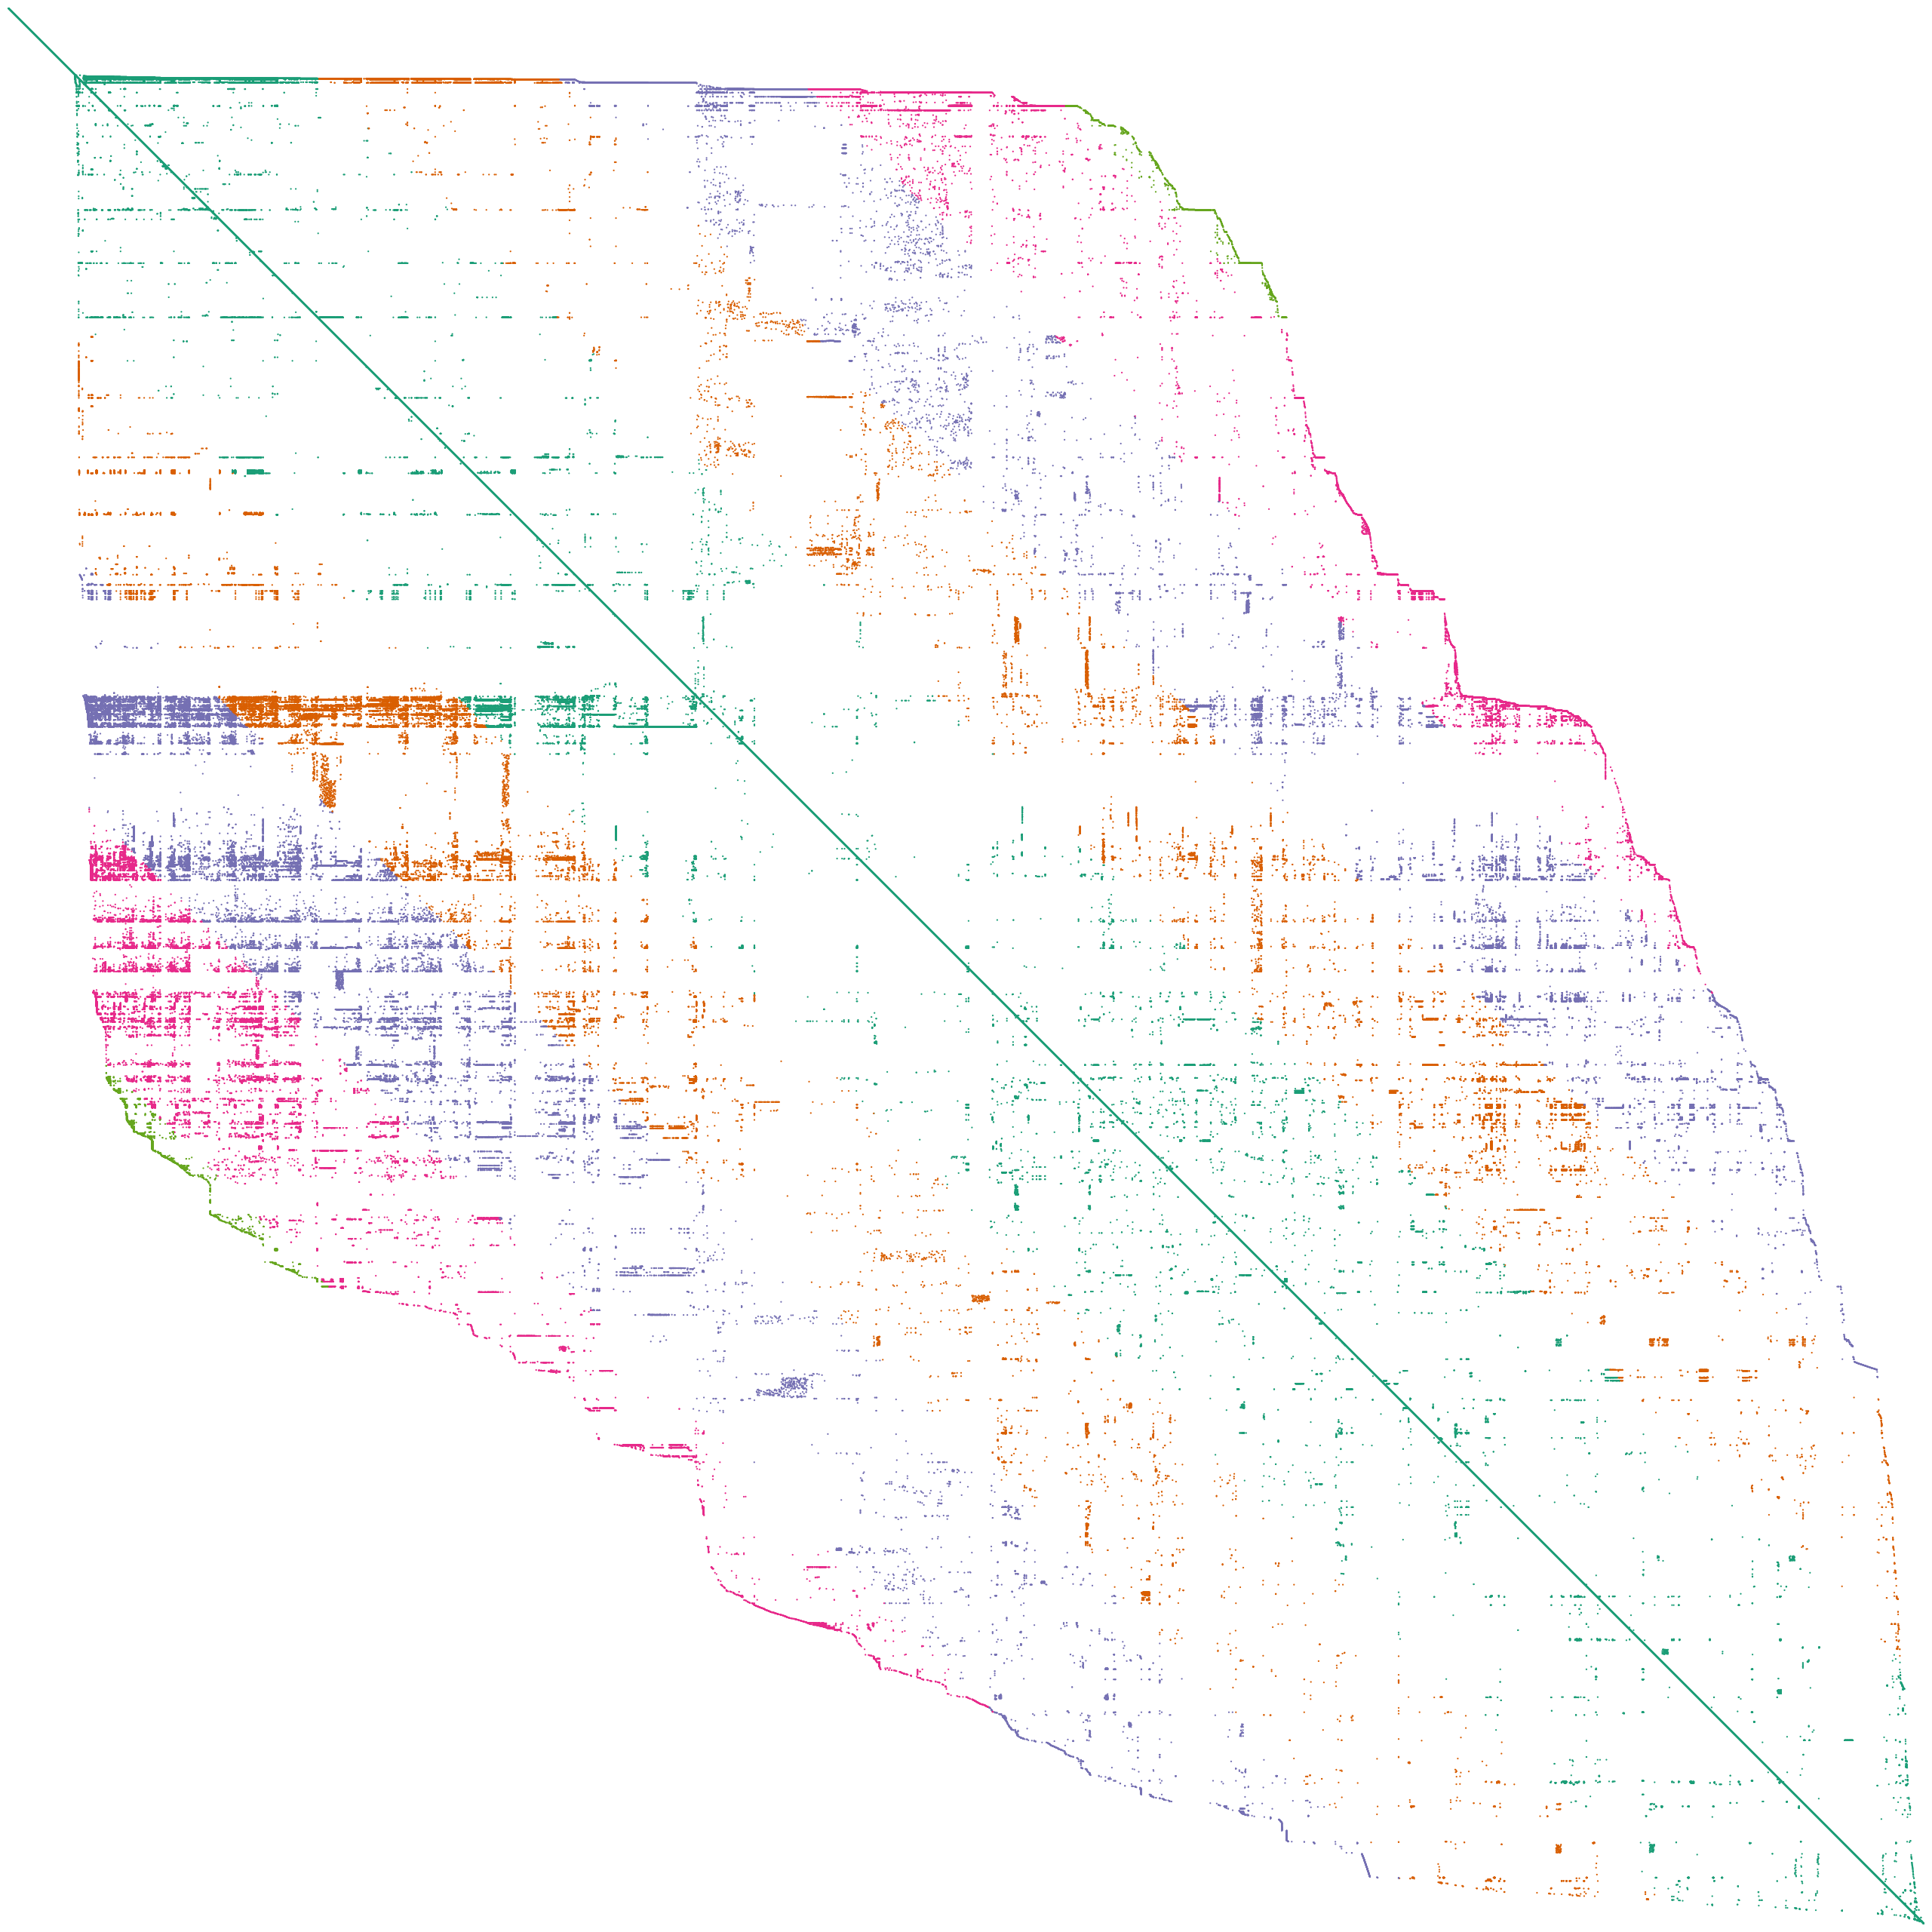

In [5]:
eidb = bd.Database("ecoinvent-3.11-cutoff")
eidb.graph_technosphere()


What this graphed technosphere means:

* Rox of pixels represent inputs to processes
* Columns of pixels represent outputs from processes
* (colors) represent the flow of materials, energy, or emissions between them.

In [6]:
random_act = eidb.random()
random_act.as_dict()

{'comment': "This is a market activity. Each market represents the consumption mix of a product in a given geography, connecting suppliers with consumers of the same product in the same geographical area. Markets group the producers and also the imports of the product (if relevant) within the same geographical area. They also account for transport to the consumer and for the losses during that process, when relevant.\nThis dataset represents the supply of 1 kg of iron(III) chloride, without water, in 14% iron solution state from activities that produce it within the geography of this dataset.\nIn this market, expert judgement was used to develop product-specific transport distance estimations based on the default transport distances for markets, provided in the 'Default Transport Assumptions' file available on the ecoinvent website (https://www.ecoinvent.org/support/documents-and-files/documents-and-files.html). See exchange comments for additional details.\nIncluded activities start: 

In [7]:
for exc in random_act.exchanges():
    print(exc)

Exchange: 1.0 kilogram 'market for iron(III) chloride, without water, in 14% iron solution state' (kilogram, GLO, None) to 'market for iron(III) chloride, without water, in 14% iron solution state' (kilogram, GLO, None)>
Exchange: 0.995557142857143 kilogram 'iron(III) chloride production, without water, in 14% iron solution state' (kilogram, RoW, None) to 'market for iron(III) chloride, without water, in 14% iron solution state' (kilogram, GLO, None)>
Exchange: 0.00444285714285714 kilogram 'iron(III) chloride production, without water, in 14% iron solution state' (kilogram, CA-QC, None) to 'market for iron(III) chloride, without water, in 14% iron solution state' (kilogram, GLO, None)>
Exchange: 0.0246 ton kilometer 'market group for transport, freight, inland waterways, barge, diesel' (ton kilometer, GLO, None) to 'market for iron(III) chloride, without water, in 14% iron solution state' (kilogram, GLO, None)>
Exchange: 0.1044 ton kilometer 'market group for transport, freight, lorry,

In [8]:
[exc for exc in random_act.exchanges()][0].as_dict()


{'flow': 'b4ad5cda-b0ec-49ae-a032-a15388e71455',
 'type': 'production',
 'name': 'iron(III) chloride, without water, in 14% iron solution state',
 'classifications': {'CPC': ['34240: Phosphates of triammonium; salts and peroxysalts of inorganic acids and metals n.e.c.']},
 'production volume': 701800643.086817,
 'properties': {'carbon allocation': {'amount': 0.0, 'unit': 'kg'},
  'carbon content': {'amount': 0.0, 'unit': 'dimensionless'},
  'carbon content, fossil': {'amount': 0.0,
   'comment': 'fossil carbon content on a dry matter basis',
   'unit': 'dimensionless'},
  'carbon content, non-fossil': {'amount': 0.0,
   'comment': 'biogene carbon content on a dry matter basis',
   'unit': 'dimensionless'},
  'dry mass': {'amount': 1.0000000000000002, 'unit': 'kg'},
  'price': {'amount': 0.4710000000000001,
   'comment': "From UN trade database. http://data.un.org/  Calculated as average price for all chemicals in the category 'Trade of goods , US$, HS 1992, 28 Inorganic chemicals, prec

## Original (trivial)
### Process Counts
#### Cleaning and Merging
First we'll look at all the technosphere processes

In [9]:
## Create a dictionary of all the country codes counts (from the technosphere activities) and convert to a dataframe
global_dict = defaultdict(int)
for act in eidb:
    cc_code = act['location']
    global_dict[cc_code] += 1

country_frame  = pd.DataFrame(list(global_dict.items()), columns=['Country', 'Process Count'])
country_frame

,Country,Process Count
0,NO,98
1,MX,72
2,CH,2710
3,IN-Southern grid,10
4,KH,8
...,...,...
327,RER w/o DE+NL+RU,1
328,IN-CH,1
329,RW,1
330,WEU,1


We want to look at these as a map; this requires:
* shapefiles for each country region (eg a global shapefile with provinces included)
* a dictionary or map to get from each country code to each shapefile 

Luckily, (if perhaps a bit oddly), the biosphere has no location detail built in. So we can just ignore it for this analysis.


Also luckily, the database overview has a geographies sheet to match what this includes. We merge this now. 

In [10]:
geographies = pd.read_excel(f"{root}/Data/Database-Overview-for-ecoinvent-v3.10_29.04.24.xlsx", sheet_name="Geographies")
country_frame = pd.merge(
    left=country_frame,
    right=geographies,
    how='inner',
    left_on='Country',
    right_on='Shortname'
)

## Clean the frame a bit further. 
country_frame.drop(columns='Country', inplace=True)
country_frame.sort_values(by='Process Count', ascending=False).head(10)


,Process Count,ID,Name,Shortname,Latitude,Longitude,Geography Classification,Contained and Overlapping Geographies
6,4673,7846b897-7c04-4f9f-b607-2b83fcd9a74c,Rest-of-World,RoW,NaN,NaN,ecoinvent Custom Area,NaN
7,4543,34dbbff8-88ce-11de-ad60-0019e336be3a,Global,GLO,NaN,NaN,World,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...
2,2710,131278d6-7d7e-11de-9ae2-0019e336be3a,Switzerland,CH,46.861000,7.908000,Country,NaN
10,2272,0723d252-7e2a-11de-9820-0019e336be3a,Europe,RER,59.970128,78.961769,ecoinvent Region,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...
29,620,f9221622-cc45-11de-98ed-0019e336be3a,Europe without Switzerland,Europe without Switzerland,48.597508,6.421103,ecoinvent Custom Area,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...
21,422,0c40fa1e-7d7e-11de-9ae2-0019e336be3a,China,CN,33.420000,106.514000,Country,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...
5,420,868a66d1-7428-4ba2-9125-253b07afc119,"Canada, Québec",CA-QC,53.390446,-71.755869,Province or State,NaN
16,326,13d387f6-7d7e-11de-9ae2-0019e336be3a,United States of America,US,39.622000,-98.606000,Country,MRO; NPCC; US-AK; US-AL; US-AR; US-ASCC; US-AZ...
19,312,0a2c8c66-7d7e-11de-9ae2-0019e336be3a,Brazil,BR,-10.772000,-53.089000,Country,BR-AC; BR-AL; BR-AM; BR-AP; BR-BA; BR-CE; BR-D...
56,297,12b21766-7d7e-11de-9ae2-0019e336be3a,South Africa,ZA,-30.558000,23.121000,Country,NaN


Explore the distribution a little 

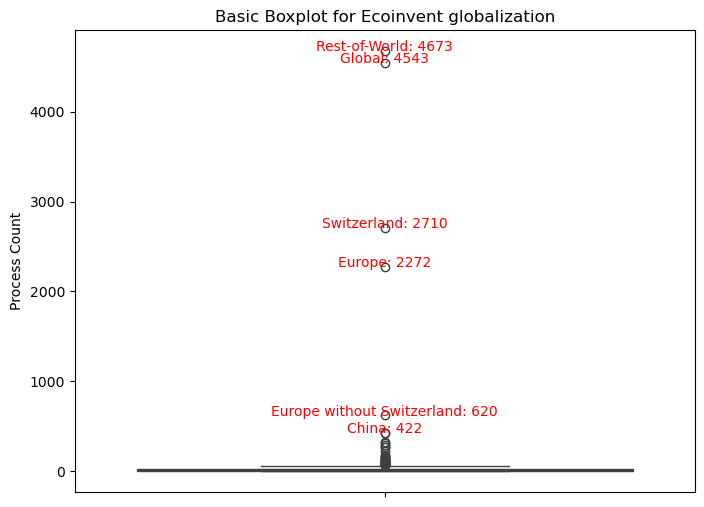

In [11]:
top5 = country_frame.sort_values(by='Process Count', ascending=False).head(6).copy()

plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=country_frame, y='Process Count')

for i, outlier in top5.iterrows():
    plt.text(0, outlier['Process Count'], f"{outlier['Name']}: {outlier['Process Count']}", color='red', ha='center')

plt.title("Basic Boxplot for Ecoinvent globalization")
plt.show()

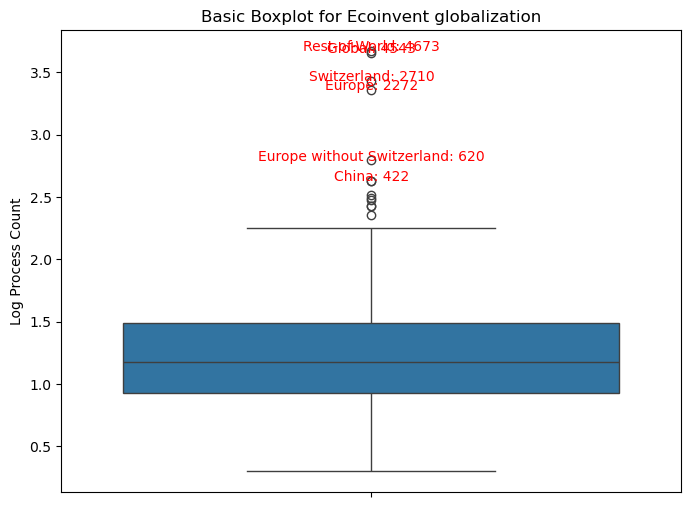

In [12]:
plt.figure(figsize=(8, 6))
country_frame['Log Process Count'] = np.log10(country_frame['Process Count'] + 1) 
top5 = country_frame.sort_values(by='Process Count', ascending=False).head(6).copy()

ax = sns.boxplot(data=country_frame, y='Log Process Count')

for i, outlier in top5.iterrows():
    plt.text(0, outlier['Log Process Count'], f"{outlier['Name']}: {outlier['Process Count']}", color='red', ha='center')

plt.title("Basic Boxplot for Ecoinvent globalization")
plt.show()

Note that:

* Global means global average production -- it **always** means that.
* Rest of World (RoW) means all the activites NOT explicitly locally defined. For example, if you have Switzerland and USA, than RoW means the global average minus those countries (from both numerator and denominator). Importantly, this means that RoW is **different** for every process (because they have different amounts of regional data).
* RoW values are not included if the regional values leave <.5% of the global production volume.

This means that in order to map RoW accurately we'd have to 'subtract' the process values we have (for that process). Luckily, at present, this seems like it wouldn't be that useful.
Source: https://support.ecoinvent.org/geographies




Note also that there are lots of non-country codes in here. Either like RoW on a smaller scale (eg, Europe without Switzerland), or other micro-regions defined by ecoquery or other organizations. For example, a regional electrical grid. In an effort to fix this, we'll have to do some parsing to try to get all the contained geographies in a machine readable format (here, ISO two letter country codes).

In [13]:
## functions for processing df rows
def get_basename(text):
    text = str(text)
    if len(text) == 2:
        return text
    
    # get the country code from the name, if it makes sense to (written in the XX- format, eg, US-CA for Caliifornia)
    match = re.search(r"..-", text) 
    return match.group(0)[:2] if match else None

def get_basenames(text):
    text = str(text)
    return [get_basename(item.strip()) for item in text.split(";")]

## create a column from the basename, and another  that lists all the contained geogrpahies in our ISO indexable format
country_frame['base_name'] = country_frame['Shortname'].apply(get_basename)
country_frame.sort_values(by='Process Count', ascending=False).head(10)


country_frame['Contained_Geographies_List'] = country_frame['Contained and Overlapping Geographies'].apply(get_basenames)


## check out the frame, looking at the largest once that have a contained geography
country_frame.dropna(subset=['Contained and Overlapping Geographies']).sort_values(by='Process Count', ascending=False).head(25)


,Process Count,ID,Name,Shortname,Latitude,Longitude,Geography Classification,Contained and Overlapping Geographies,Log Process Count,base_name,Contained_Geographies_List
7,4543,34dbbff8-88ce-11de-ad60-0019e336be3a,Global,GLO,NaN,NaN,World,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...,3.657438,None,"[AD, AE, AF, AG, AI, None, AL, AM, AO, AQ, AR,..."
10,2272,0723d252-7e2a-11de-9820-0019e336be3a,Europe,RER,59.970128,78.961769,ecoinvent Region,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,3.356599,None,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N..."
29,620,f9221622-cc45-11de-98ed-0019e336be3a,Europe without Switzerland,Europe without Switzerland,48.597508,6.421103,ecoinvent Custom Area,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,2.793092,None,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N..."
21,422,0c40fa1e-7d7e-11de-9ae2-0019e336be3a,China,CN,33.420000,106.514000,Country,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...,2.626340,CN,"[None, CN, CN, CN, CN, CN, CN, CN, CN, CN, CN,..."
16,326,13d387f6-7d7e-11de-9ae2-0019e336be3a,United States of America,US,39.622000,-98.606000,Country,MRO; NPCC; US-AK; US-AL; US-AR; US-ASCC; US-AZ...,2.514548,US,"[None, None, US, US, US, US, US, US, US, US, U..."
19,312,0a2c8c66-7d7e-11de-9ae2-0019e336be3a,Brazil,BR,-10.772000,-53.089000,Country,BR-AC; BR-AL; BR-AM; BR-AP; BR-BA; BR-CE; BR-D...,2.495544,BR,"[BR, BR, BR, BR, BR, BR, BR, BR, BR, BR, BR, B..."
33,268,0e6a7860-7d7e-11de-9ae2-0019e336be3a,India,IN,21.000000,78.500000,Country,IN-AN; IN-AP; IN-AR; IN-AS; IN-BR; IN-CH; IN-C...,2.429752,IN,"[IN, IN, IN, IN, IN, IN, IN, IN, IN, IN, IN, I..."
84,170,12ea642c-7d7e-11de-9ae2-0019e336be3a,Spain,ES,40.227000,-3.649000,Country,Canary Islands,2.232996,ES,[None]
34,117,12143bfe-7d7e-11de-9ae2-0019e336be3a,Russia,RU,61.847380,97.037378,Country,Asia without China; Europe without Austria; Eu...,2.071882,RU,"[None, None, None, None, None, None, None, Non..."
36,107,0fecb5e8-7e2a-11de-9820-0019e336be3a,Northern America,RNA,58.710600,-91.968294,UN Subregion,BM; CA; CA-AB; CA-BC; CA-MB; Canada without Al...,2.033424,None,"[BM, CA, CA, CA, CA, None, None, None, CA, CA,..."


There are two categories of contained geography here:
* Those that **obscure** locality. For example, Europe except Switzerland is basically just Europe. It makes sense in opposition to Switzerland, but I don't think we should count it as local data for all the sub regions -- that is, add the process count to all the countries included. Instead, we'll just add it to the Europe category for the 
* Those that **enhance** locality. For example. All the regional electricity grids, such as India, Eastern grid. We need to bear these in mind when we are doing heatmap data or trying to subdivide countries. Otherwise, we can just take the sum and add it to the country as a whole to get a good indication of **national** level process counts.

In [14]:
## if the list column is all for sub-localities of the same place, we can just say that it's all for that place
def update_single_val(row):
    list_vals = row['Contained_Geographies_List']
    single_val = row['base_name']
    
    if single_val is None and len(set(list_vals)) == 1:
        row['single_col'] = list_vals[0]  # Update single_val to the value in the list
    return row

country_frame = country_frame.apply(update_single_val, axis=1)
country_frame.dropna(subset=['Contained and Overlapping Geographies']).sort_values(by='Process Count', ascending=False).head(25)


,Contained and Overlapping Geographies,Contained_Geographies_List,Geography Classification,ID,Latitude,Log Process Count,Longitude,Name,Process Count,Shortname,base_name,single_col
7,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...,"[AD, AE, AF, AG, AI, None, AL, AM, AO, AQ, AR,...",World,34dbbff8-88ce-11de-ad60-0019e336be3a,NaN,3.657438,NaN,Global,4543,GLO,None,NaN
10,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Region,0723d252-7e2a-11de-9820-0019e336be3a,59.970128,3.356599,78.961769,Europe,2272,RER,None,NaN
29,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Custom Area,f9221622-cc45-11de-98ed-0019e336be3a,48.597508,2.793092,6.421103,Europe without Switzerland,620,Europe without Switzerland,None,NaN
21,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...,"[None, CN, CN, CN, CN, CN, CN, CN, CN, CN, CN,...",Country,0c40fa1e-7d7e-11de-9ae2-0019e336be3a,33.420000,2.626340,106.514000,China,422,CN,CN,NaN
16,MRO; NPCC; US-AK; US-AL; US-AR; US-ASCC; US-AZ...,"[None, None, US, US, US, US, US, US, US, US, U...",Country,13d387f6-7d7e-11de-9ae2-0019e336be3a,39.622000,2.514548,-98.606000,United States of America,326,US,US,NaN
19,BR-AC; BR-AL; BR-AM; BR-AP; BR-BA; BR-CE; BR-D...,"[BR, BR, BR, BR, BR, BR, BR, BR, BR, BR, BR, B...",Country,0a2c8c66-7d7e-11de-9ae2-0019e336be3a,-10.772000,2.495544,-53.089000,Brazil,312,BR,BR,NaN
33,IN-AN; IN-AP; IN-AR; IN-AS; IN-BR; IN-CH; IN-C...,"[IN, IN, IN, IN, IN, IN, IN, IN, IN, IN, IN, I...",Country,0e6a7860-7d7e-11de-9ae2-0019e336be3a,21.000000,2.429752,78.500000,India,268,IN,IN,NaN
84,Canary Islands,[None],Country,12ea642c-7d7e-11de-9ae2-0019e336be3a,40.227000,2.232996,-3.649000,Spain,170,ES,ES,NaN
34,Asia without China; Europe without Austria; Eu...,"[None, None, None, None, None, None, None, Non...",Country,12143bfe-7d7e-11de-9ae2-0019e336be3a,61.847380,2.071882,97.037378,Russia,117,RU,RU,NaN
36,BM; CA; CA-AB; CA-BC; CA-MB; Canada without Al...,"[BM, CA, CA, CA, CA, None, None, None, CA, CA,...",UN Subregion,0fecb5e8-7e2a-11de-9820-0019e336be3a,58.710600,2.033424,-91.968294,Northern America,107,RNA,None,NaN


In [15]:
cont_codes = pd.read_csv(f"{root}/Data/indexing_csvs/country-and-continent-codes-list.csv")
cont_codes

,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
0,Asia,AS,"Afghanistan, Islamic Republic of",AF,AFG,4.0
1,Europe,EU,"Albania, Republic of",AL,ALB,8.0
2,Antarctica,AN,Antarctica (the territory South of 60 deg S),AQ,ATA,10.0
3,Africa,AF,"Algeria, People's Democratic Republic of",DZ,DZA,12.0
4,Oceania,OC,American Samoa,AS,ASM,16.0
...,...,...,...,...,...,...
257,Africa,AF,"Zambia, Republic of",ZM,ZMB,894.0
258,Oceania,OC,Disputed Territory,XX,NaN,NaN
259,Asia,AS,Iraq-Saudi Arabia Neutral Zone,XE,NaN,NaN
260,Asia,AS,United Nations Neutral Zone,XD,NaN,NaN


In [16]:
country_frame[country_frame['Name'] == 'Europe']

,Contained and Overlapping Geographies,Contained_Geographies_List,Geography Classification,ID,Latitude,Log Process Count,Longitude,Name,Process Count,Shortname,base_name,single_col
10,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Region,0723d252-7e2a-11de-9820-0019e336be3a,59.970128,3.356599,78.961769,Europe,2272,RER,None,NaN


This looks good, so now we merge with an ISO sheet for continent and region indexing.

In [17]:
## First we merge with the named Continents directly
cont_codes = pd.read_csv(f"{root}/Data/indexing_csvs/country-and-continent-codes-list.csv")
conts_only = cont_codes['Continent_Name'].value_counts().reset_index().drop(columns='count')
cont_frame = pd.merge(
    left=country_frame,
    right=conts_only,
    left_on='Name',
    right_on='Continent_Name',
    how='inner'
)
cont_frame

,Contained and Overlapping Geographies,Contained_Geographies_List,Geography Classification,ID,Latitude,Log Process Count,Longitude,Name,Process Count,Shortname,base_name,single_col,Continent_Name
0,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Region,0723d252-7e2a-11de-9820-0019e336be3a,59.970128,3.356599,78.961769,Europe,2272,RER,None,NaN,Europe
1,AS; AU; AU-ACT; AU-JBT; AU-NSW; AU-NT; AU-QLD;...,"[AS, AU, AU, AU, AU, AU, AU, AU, AU, AU, AU, C...",UN Region,9232290c-e62b-11de-ba56-0019e336be3a,-25.282887,1.322219,136.406721,Oceania,20,UN-OCEANIA,UN,NaN,Oceania
2,AO; BF; BI; BJ; BW; CD; CF; CG; CM; CV; DJ; DZ...,"[AO, BF, BI, BJ, BW, CD, CF, CG, CM, CV, DJ, D...",UN Region,2f693dc6-7e28-11de-9820-0019e336be3a,6.417882,1.000000,18.287021,Africa,9,RAF,None,NaN,Africa
3,AE; AF; Akrotiri; AM; Asia without China; AZ; ...,"[AE, AF, None, AM, None, AZ, BD, BH, BN, BT, N...",ecoinvent Region,19c7cdd2-e590-11de-9dfe-0019e336be3a,45.201180,1.544068,96.075924,Asia,34,RAS,None,NaN,Asia


In [18]:
## Now we merge with the basenames, dropping those that don't have a basename
country_frame_redux = pd.merge(
    left=country_frame.dropna(subset=['base_name']),
    right=cont_codes,
    left_on='base_name',
    right_on='Two_Letter_Country_Code',
    how='left'
)
country_frame_redux.sort_values(by='Process Count', ascending=False).head(4)

,Contained and Overlapping Geographies,Contained_Geographies_List,Geography Classification,ID,Latitude,Log Process Count,Longitude,Name,Process Count,Shortname,base_name,single_col,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
2,NaN,[None],Country,131278d6-7d7e-11de-9ae2-0019e336be3a,46.861000,3.433130,7.908000,Switzerland,2710,CH,CH,NaN,Europe,EU,"Switzerland, Swiss Confederation",CH,CHE,756.0
18,China w/o Inner Mongol; CN-AH; CN-BJ; CN-CCG; ...,"[None, CN, CN, CN, CN, CN, CN, CN, CN, CN, CN,...",Country,0c40fa1e-7d7e-11de-9ae2-0019e336be3a,33.420000,2.626340,106.514000,China,422,CN,CN,NaN,Asia,AS,"China, People's Republic of",CN,CHN,156.0
5,NaN,[None],Province or State,868a66d1-7428-4ba2-9125-253b07afc119,53.390446,2.624282,-71.755869,"Canada, Québec",420,CA-QC,CA,NaN,North America,NaN,Canada,CA,CAN,124.0
13,MRO; NPCC; US-AK; US-AL; US-AR; US-ASCC; US-AZ...,"[None, None, US, US, US, US, US, US, US, US, U...",Country,13d387f6-7d7e-11de-9ae2-0019e336be3a,39.622000,2.514548,-98.606000,United States of America,326,US,US,NaN,North America,NaN,United States of America,US,USA,840.0


In [19]:
## Get those countries who don't connect and remove them.

unlabeled = country_frame[country_frame['base_name'].isna()].sort_values(by='Process Count', ascending=False)
unlabeled[unlabeled['Process Count'] > 15]

,Contained and Overlapping Geographies,Contained_Geographies_List,Geography Classification,ID,Latitude,Log Process Count,Longitude,Name,Process Count,Shortname,base_name,single_col
6,NaN,[None],ecoinvent Custom Area,7846b897-7c04-4f9f-b607-2b83fcd9a74c,NaN,3.669689,NaN,Rest-of-World,4673,RoW,None,NaN
7,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...,"[AD, AE, AF, AG, AI, None, AL, AM, AO, AQ, AR,...",World,34dbbff8-88ce-11de-ad60-0019e336be3a,NaN,3.657438,NaN,Global,4543,GLO,None,NaN
10,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Region,0723d252-7e2a-11de-9820-0019e336be3a,59.970128,3.356599,78.961769,Europe,2272,RER,None,NaN
29,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Custom Area,f9221622-cc45-11de-98ed-0019e336be3a,48.597508,2.793092,6.421103,Europe without Switzerland,620,Europe without Switzerland,None,NaN
36,BM; CA; CA-AB; CA-BC; CA-MB; Canada without Al...,"[BM, CA, CA, CA, CA, None, None, None, CA, CA,...",UN Subregion,0fecb5e8-7e2a-11de-9820-0019e336be3a,58.710600,2.033424,-91.968294,Northern America,107,RNA,None,NaN
37,NaN,[None],ecoinvent Custom Area,81e54bf8-5993-5b5b-bc50-6978cab0c51f,NaN,1.806180,NaN,Rest of Europe,63,RoE,None,NaN
230,AE; AF; Akrotiri; AM; Asia without China; AZ; ...,"[AE, AF, None, AM, None, AZ, BD, BH, BN, BT, N...",ecoinvent Region,19c7cdd2-e590-11de-9dfe-0019e336be3a,45.201180,1.544068,96.075924,Asia,34,RAS,None,NaN
185,Canary Islands; CENTREL; DE; ES; Europe withou...,"[None, None, DE, ES, None, None, FR, None, GB,...",Aluminium Industry,b7fcfda9-0add-49aa-87d4-d60f3bda4283,NaN,1.505150,NaN,"IAI Area, EU27 & EFTA",31,"IAI Area, EU27 & EFTA",None,NaN
94,AG; AI; AR; AW; BB; BL; BO; BQ; BR; BR-AC; BR-...,"[AG, AI, AR, AW, BB, BL, BO, BQ, BR, BR, BR, B...",UN Subregion,09db3260-7e2a-11de-9820-0019e336be3a,-10.119415,1.505150,-65.624398,Latin America and the Caribbean,31,RLA,None,NaN
287,CA-AB; CA-BC; CA-MB; Canada without Alberta; C...,"[CA, CA, CA, None, None, CA, CA, CA, CA, CA, C...",ecoinvent Custom Area,a4d7d7fd-94ae-4f44-91ba-53cd7f79bac4,NaN,1.230449,NaN,Canada without Quebec,16,Canada without Quebec,None,NaN


In [20]:
## Some of them we have to just label by hand
mappings = {
    'Rest-of-World': 'Global',
    'global': 'Global',
    'Europe without Switzerland': 'Europe',
    'Canada without Quebec': 'North America',
    'Rest of Europe': 'Europe',
    'Northern America': 'North America',
    'Latin America and the Caribbean': 'South America'

}

unlabeled['Continent_Name'] = unlabeled['Name'].map(mappings)

In [21]:
country_frame_merged_cont = pd.concat([unlabeled, country_frame_redux, cont_frame], axis=0, ignore_index=True)

print(country_frame.shape, country_frame_merged_cont.shape)

(331, 12) (342, 18)


In [22]:
country_frame_merged_cont

,Contained and Overlapping Geographies,Contained_Geographies_List,Geography Classification,ID,Latitude,Log Process Count,Longitude,Name,Process Count,Shortname,base_name,single_col,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number
0,NaN,[None],ecoinvent Custom Area,7846b897-7c04-4f9f-b607-2b83fcd9a74c,NaN,3.669689,NaN,Rest-of-World,4673,RoW,None,NaN,Global,NaN,NaN,NaN,NaN,NaN
1,AD; AE; AF; AG; AI; Akrotiri; AL; AM; AO; AQ; ...,"[AD, AE, AF, AG, AI, None, AL, AM, AO, AQ, AR,...",World,34dbbff8-88ce-11de-ad60-0019e336be3a,NaN,3.657438,NaN,Global,4543,GLO,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Region,0723d252-7e2a-11de-9820-0019e336be3a,59.970128,3.356599,78.961769,Europe,2272,RER,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Custom Area,f9221622-cc45-11de-98ed-0019e336be3a,48.597508,2.793092,6.421103,Europe without Switzerland,620,Europe without Switzerland,None,NaN,Europe,NaN,NaN,NaN,NaN,NaN
4,BM; CA; CA-AB; CA-BC; CA-MB; Canada without Al...,"[BM, CA, CA, CA, CA, None, None, None, CA, CA,...",UN Subregion,0fecb5e8-7e2a-11de-9820-0019e336be3a,58.710600,2.033424,-91.968294,Northern America,107,RNA,None,NaN,North America,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,NaN,[None],Country,129718da-7d7e-11de-9ae2-0019e336be3a,-1.998000,0.301030,29.917000,Rwanda,1,RW,RW,NaN,Africa,AF,"Rwanda, Republic of",RW,RWA,646.0
338,AD; AL; AT; AX; BA; BALTSO; BE; BG; BY; Canary...,"[AD, AL, AT, AX, BA, None, BE, BG, BY, None, N...",ecoinvent Region,0723d252-7e2a-11de-9820-0019e336be3a,59.970128,3.356599,78.961769,Europe,2272,RER,None,NaN,Europe,NaN,NaN,NaN,NaN,NaN
339,AS; AU; AU-ACT; AU-JBT; AU-NSW; AU-NT; AU-QLD;...,"[AS, AU, AU, AU, AU, AU, AU, AU, AU, AU, AU, C...",UN Region,9232290c-e62b-11de-ba56-0019e336be3a,-25.282887,1.322219,136.406721,Oceania,20,UN-OCEANIA,UN,NaN,Oceania,NaN,NaN,NaN,NaN,NaN
340,AO; BF; BI; BJ; BW; CD; CF; CG; CM; CV; DJ; DZ...,"[AO, BF, BI, BJ, BW, CD, CF, CG, CM, CV, DJ, D...",UN Region,2f693dc6-7e28-11de-9820-0019e336be3a,6.417882,1.000000,18.287021,Africa,9,RAF,None,NaN,Africa,NaN,NaN,NaN,NaN,NaN


In [23]:
country_frame_merged_cont['Two_Letter_Country_Code'].value_counts()

Two_Letter_Country_Code
CN    40
IN    39
BR    32
US    26
CA    14
      ..
ER     1
JM     1
GI     1
SN     1
RW     1
Name: count, Length: 144, dtype: int64

In [24]:
country_frame_combined.sort_values(by='Process Count_summed', ascending=False)

NameError: name 'country_frame_combined' is not defined

#### Figures

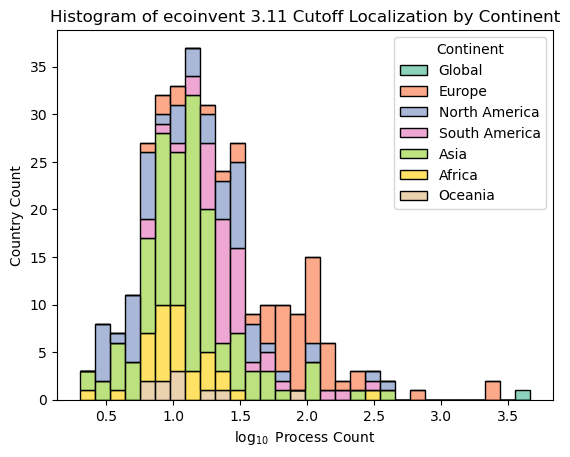

In [ ]:
# Stacked histogram with hue for coloring
sns.histplot(
    data=country_frame_merged_cont,
    x=country_frame_merged_cont['Log Process Count'],  # Log-transform
    hue='Continent_Name',                                 
    multiple='stack',                                 
    bins=30,
    palette='Set2'                                  
)

# Labels and title
plt.xlabel(r"$\log_{10}$ Process Count")
plt.ylabel("Country Count")
plt.title("Histogram of ecoinvent 3.11 Cutoff Localization by Continent")
legend = plt.gca().get_legend() 
legend.set_title('Continent') 


plt.savefig(f"{root}/Figures/Basic_Viz/Line and Bargraphs/ecoinvent_localization_hist.png", bbox_inches='tight')

plt.show()

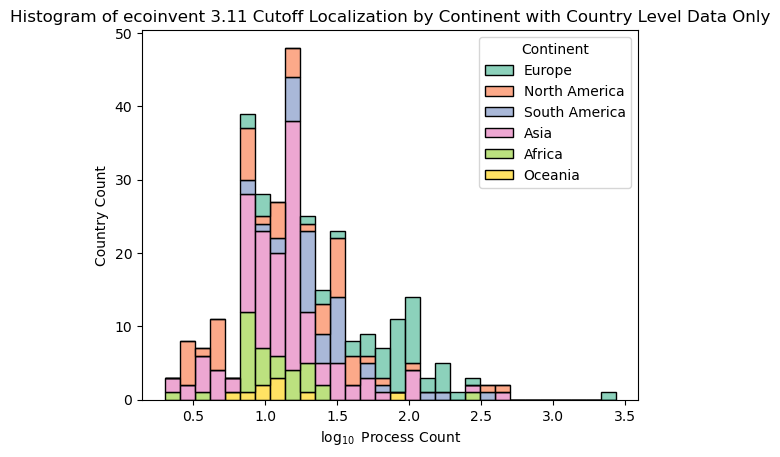

In [ ]:
# Stacked histogram with hue for coloring
sns.histplot(
    data=country_frame_redux,
    x=country_frame_redux['Log Process Count'],  # Log-transform
    hue='Continent_Name',                                 
    multiple='stack',                                 
    bins=30,
    palette='Set2'                                  
)

# Labels and title
plt.xlabel(r"$\log_{10}$ Process Count")
plt.ylabel("Country Count")
plt.title("Histogram of ecoinvent 3.11 Cutoff Localization by Continent with Country Level Data Only")
legend = plt.gca().get_legend() 
legend.set_title('Continent') 

plt.savefig(f"{root}/Figures/Basic_Viz/Line and Bargraphs/ecoinvent_localization_hist_country_only.png", bbox_inches='tight')

plt.show()

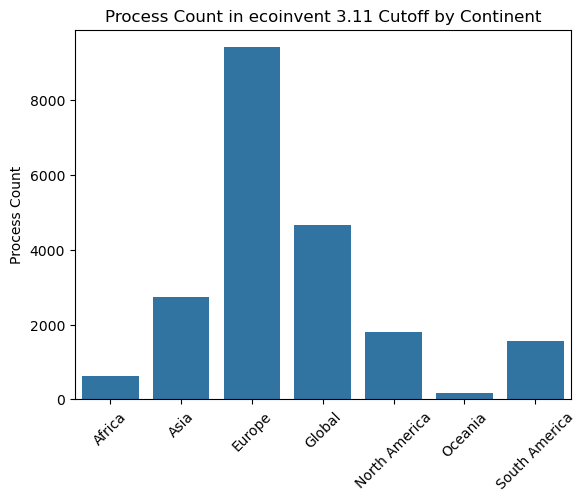

In [ ]:
continent_frame = country_frame_merged_cont.groupby(country_frame_merged_cont['Continent_Name'])['Process Count'].sum().reset_index()
sns.barplot(data=continent_frame, x='Continent_Name', y='Process Count')
plt.xlabel("")
plt.title("Process Count in ecoinvent 3.11 Cutoff by Continent")
plt.xticks(rotation=45)
plt.savefig(f"{root}/Figures/Basic_Viz/Line and Bargraphs/Process_count_by_continent.png")
plt.show()

### Economic Plots

In [ ]:
gdp_frame = pd.read_csv(f"{root}/Data/indexing_csvs/API_NY.GDP.MKTP.CD_DS2_en_csv_v2_88.csv")

In order to make the gdp make sense we need to conglomerate all the territory process counts

In [ ]:
# Grouping by 'Two_Letter_Country_Code' and summing 'Process Count'
country_frame_merged_cont_grouped = (
    country_frame_merged_cont
    .groupby('Two_Letter_Country_Code', as_index=False)['Process Count']
    .sum()
)

# Merging the grouped sums back to the original DataFrame
country_frame_merged_cont_grouped = country_frame_merged_cont.merge(
    country_frame_merged_cont_grouped[['Two_Letter_Country_Code', 'Process Count']], 
    on='Two_Letter_Country_Code', 
    how='left', 
    suffixes=('', '_summed')
)

# Creating 'Log Process Count' as the log10 of the summed 'Process Count'
country_frame_merged_cont_grouped['Log Process Count_summed'] = np.log10(
    country_frame_merged_cont_grouped['Process Count_summed']
)

country_frame_combined = country_frame_merged_cont_grouped.groupby('Two_Letter_Country_Code', as_index=False).agg({
    'Process Count_summed': 'mean',  # Summing 'Process Count'
    'Log Process Count_summed': 'mean'  # Optionally, taking the mean of 'Log Process Count' or another aggregation
})

country_frame_merged_cont_grouped = country_frame_merged_cont_grouped.drop_duplicates(
    subset='Two_Letter_Country_Code', 
    keep='first'
)

In [ ]:
country_frame_merged_cont_grouped.sort_values(by='Process Count_summed', ascending=False)

,Contained and Overlapping Geographies,Contained_Geographies_List,Geography Classification,ID,Latitude,Log Process Count,Longitude,Name,Process Count,Shortname,base_name,single_col,Continent_Name,Continent_Code,Country_Name,Two_Letter_Country_Code,Three_Letter_Country_Code,Country_Number,Process Count_summed,Log Process Count_summed
43,NaN,[None],Country,131278d6-7d7e-11de-9ae2-0019e336be3a,46.861000,3.433130,7.908000,Switzerland,2710,CH,CH,NaN,Europe,EU,"Switzerland, Swiss Confederation",CH,CHE,756.0,2710.0,3.432969
38,BR-AL; BR-BA; BR-CE; BR-MA; BR-PB; BR-PE; BR-P...,"[BR, BR, BR, BR, BR, BR, BR, BR, BR]",Electricity Grid,3ece4ff8-55ae-40b2-baea-0d2bf2034fbf,NaN,1.301030,NaN,"Brazil, North-eastern grid",19,BR-North-eastern grid,BR,NaN,South America,SA,"Brazil, Federative Republic of",BR,BRA,76.0,994.0,2.997386
49,NaN,[None],Electricity Grid,094ba255-b84b-5fbd-8c8a-75547f362075,NaN,0.954243,NaN,"China, Southwest Grid",8,CN-SWG,CN,NaN,Asia,AS,"China, People's Republic of",CN,CHN,156.0,983.0,2.992554
32,NaN,[None],Province or State,868a66d1-7428-4ba2-9125-253b07afc119,53.390446,2.624282,-71.755869,"Canada, Québec",420,CA-QC,CA,NaN,North America,NaN,Canada,CA,CAN,124.0,845.0,2.926857
42,MRO; NPCC; US-AK; US-AL; US-AR; US-ASCC; US-AZ...,"[None, None, US, US, US, US, US, US, US, US, U...",Country,13d387f6-7d7e-11de-9ae2-0019e336be3a,39.622000,2.514548,-98.606000,United States of America,326,US,US,NaN,North America,NaN,United States of America,US,USA,840.0,643.0,2.808211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,NaN,[None],Country,c08de0ce-64e7-4efb-a37f-8df754c262c8,NaN,0.845098,NaN,Curaçao,6,CW,CW,NaN,North America,NaN,Curaçao,CW,CUW,531.0,6.0,0.778151
161,NaN,[None],Country,11663ae0-7d7e-11de-9ae2-0019e336be3a,-5.949000,0.778151,143.459000,Papua New Guinea,5,PG,PG,NaN,Oceania,OC,"Papua New Guinea, Independent State of",PG,PNG,598.0,5.0,0.698970
336,AD; AT; AX; BA; BALTSO; BE; BG; Canary Islands...,"[AD, AT, AX, BA, None, BE, BG, None, None, CH,...",Electricity Grid,f87aa98c-d820-11de-a736-0019e336be3a,NaN,0.602060,NaN,European Network of Transmission Systems Opera...,3,ENTSO-E,SO,NaN,Africa,AF,"Somalia, Somali Republic",SO,SOM,706.0,3.0,0.477121
337,NaN,[None],Country,129718da-7d7e-11de-9ae2-0019e336be3a,-1.998000,0.301030,29.917000,Rwanda,1,RW,RW,NaN,Africa,AF,"Rwanda, Republic of",RW,RWA,646.0,1.0,0.000000


In [ ]:
merged_gdp = pd.merge(
    left=country_frame_merged_cont_grouped,
    right=gdp_frame,
    left_on='Three_Letter_Country_Code',
    right_on='Country Code',
    how='inner',
)

merged_gdp['log_gdp'] = np.log10(merged_gdp['2022'])
merged_gdp


,Contained and Overlapping Geographies,Contained_Geographies_List,Geography Classification,ID,Latitude,Log Process Count,Longitude,Name,Process Count,Shortname,...,2016,2017,2018,2019,2020,2021,2022,2023,Unnamed: 68,log_gdp
0,NaN,[None],Country,0e0e1020-7d7e-11de-9ae2-0019e336be3a,51.110000,2.424882,9.851000,Germany,265,DE,...,3.537784e+12,3.763092e+12,4.052008e+12,3.957208e+12,3.940143e+12,4.348297e+12,4.163596e+12,4.525704e+12,NaN,12.619469
1,NaN,[None],Province or State,868a66d1-7428-4ba2-9125-253b07afc119,53.390446,2.624282,-71.755869,"Canada, Québec",420,CA-QC,...,1.527995e+12,1.649266e+12,1.725329e+12,1.743725e+12,1.655685e+12,2.007472e+12,2.161483e+12,2.142471e+12,NaN,12.334752
2,NaN,[None],Country,13725fee-7d7e-11de-9ae2-0019e336be3a,53.000000,2.193125,-1.600000,United Kingdom,155,GB,...,2.689107e+12,2.680148e+12,2.871340e+12,2.851407e+12,2.696778e+12,3.143323e+12,3.114042e+12,3.380855e+12,NaN,12.493325
3,Europe without NORDEL (NCPA); NORDEL; UCTE; UC...,"[None, None, None, None, None, None]",Country,0cf950f0-7d7e-11de-9ae2-0019e336be3a,56.058000,1.929419,9.264000,Denmark,84,DK,...,3.121818e+11,3.316106e+11,3.552934e+11,3.454015e+11,3.556310e+11,4.083782e+11,4.019456e+11,4.070919e+11,NaN,11.604167
4,NaN,[None],Country,115c647a-7d7e-11de-9ae2-0019e336be3a,40.309000,1.924279,-8.058000,Portugal,83,PT,...,2.063054e+11,2.208630e+11,2.420929e+11,2.401160e+11,2.296188e+11,2.560559e+11,2.568987e+11,2.891143e+11,NaN,11.409762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,NaN,[None],Country,0ff7be54-7d7e-11de-9ae2-0019e336be3a,22.423000,0.903090,114.129000,Hong Kong S.A.R.,7,HK,...,3.208603e+11,3.412733e+11,3.617311e+11,3.630745e+11,3.449431e+11,3.689542e+11,3.586811e+11,3.808122e+11,NaN,11.554708
139,NaN,[None],Country,111cdba2-7d7e-11de-9ae2-0019e336be3a,12.840000,1.041393,-85.034000,Nicaragua,10,NI,...,1.328610e+10,1.378592e+10,1.302523e+10,1.269903e+10,1.268157e+10,1.414406e+10,1.564990e+10,1.782922e+10,NaN,10.194511
140,NaN,[None],Country,c08de0ce-64e7-4efb-a37f-8df754c262c8,NaN,0.845098,NaN,Curaçao,6,CW,...,3.024690e+09,3.033433e+09,3.046365e+09,3.026124e+09,2.534328e+09,2.739608e+09,3.075181e+09,3.281419e+09,NaN,9.487871
141,AD; AT; AX; BA; BALTSO; BE; BG; Canary Islands...,"[AD, AT, AX, BA, None, BE, BG, None, None, CH,...",Electricity Grid,f87aa98c-d820-11de-a736-0019e336be3a,NaN,0.602060,NaN,European Network of Transmission Systems Opera...,3,ENTSO-E,...,6.613743e+09,7.621502e+09,7.873441e+09,8.655024e+09,8.628394e+09,9.483997e+09,1.020277e+10,1.096852e+10,NaN,10.008718


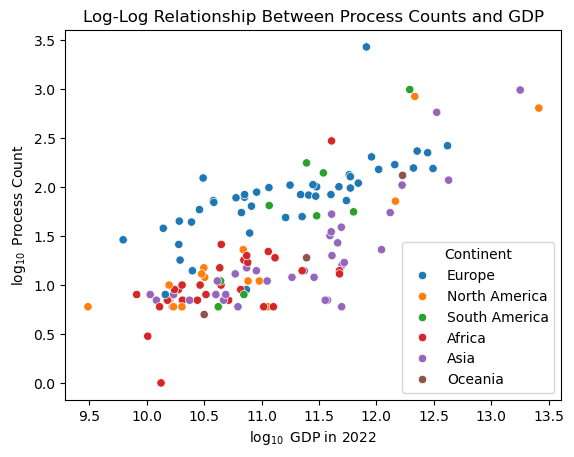

In [ ]:
sns.scatterplot(data=merged_gdp, y='Log Process Count_summed', x='log_gdp', hue='Continent_Name')
plt.title("Log-Log Relationship Between Process Counts and GDP")
plt.ylabel(r"$\log_{10}$ Process Count")
plt.xlabel(r"$\log_{10}$ GDP in 2022")
legend = plt.gca().get_legend() 
legend.set_title('Continent') 
plt.savefig(f"{root}/Figures/Basic_Viz/Line and Bargraphs/GDP_Process_Scatterplot.png")
plt.show()


### Geomapping

#### Load in Shapefiles

In [ ]:
states = gpd.read_file(f"{root}/Data/Shapefiles/Natural_earth_states_provinces_all/ne_10m_admin_1_states_provinces.shp")
states.head(3)

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,Admin-1 states provinces,3,ARG-1309,1309,AR-E,None,AR,1,Entre Ríos,Entre-Rios,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-58.20011 -32.44713, -58.20012 -32.4..."
1,Admin-1 states provinces,6,URY-8,8,UY-PA,None,UY,1,Paysandú,None,...,None,None,None,None,None,None,None,None,None,"POLYGON ((-58.20012 -32.4472, -58.20011 -32.44..."
2,Admin-1 states provinces,2,IDN-1185,1185,ID-KI,None,ID,5,Kalimantan Timur,Kaltim,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."


In [ ]:
countries = gpd.read_file(f"{root}/Data/Shapefiles/Natural_earth_countries_all/ne_10m_admin_0_countries.shp")
# for col in countries.columns:
#     print(col)
countries[countries['ISO_A2'] == 'US']


## Using this commented code we figure out that norway and france, as well as some dispute countries, don't have ISO codes. As we'll use these for merging, 
## we just manually fix them. 
# problem_rows = countries[countries['ISO_A2'] == '-99']
# print(problem_rows[['NAME', 'ISO_A2', 'ISO_A3']])

fixes = {
    'France': {'ISO_A2': 'FR', 'ISO_A3': 'FRA'},
    'Norway': {'ISO_A2': 'NO', 'ISO_A3': 'NOR'},
    'Kosovo': {'ISO_A2': 'XK', 'ISO_A3': 'XKX'},       
    'Somaliland': {'ISO_A2': 'SO', 'ISO_A3': 'SOL'},   
}

for name, codes in fixes.items():
    countries.loc[countries['NAME'] == name, ['ISO_A2', 'ISO_A3']] = codes['ISO_A2'], codes['ISO_A3']

In [ ]:

## get all the non-country territories 
matched_territories = pd.merge(
    left = country_frame_merged_cont,
    right = states,
    how = 'inner',
    left_on = 'Shortname',
    right_on = 'iso_3166_2'
)

# countries_left = country_frame_merged_cont[~country_frame_merged_cont['Shortname'].isin(matched_territories['Shortname'])]
# countries_left

## get all the country-level territories
matched_countries = pd.merge(
    left = country_frame_merged_cont,
    right = countries,
    how = 'inner',
    left_on = 'Two_Letter_Country_Code',
    right_on = 'ISO_A2'
)

# ## for a final frame, un-localize the territory level processes to the country-level
# grouped = matched_territories.groupby(matched_territories['Shortname'].str[:2])['Process Count'].sum().reset_index() ## add the 
# matched_added = pd.merge(
#     matched_countries, grouped, on='Shortname', how='outer', suffixes=('_df1', '_df2'))
# matched_added
# matched_added['Process Count'] = matched_added['Process Count_df1'].fillna(0) + matched_added['Process Count_df2'].fillna(0)


## for a final frame, un-localize the territory level processes to the country-level using the model we used for GDP
country_frame_merged_cont_grouped_gdf = pd.merge(
    left = country_frame_merged_cont_grouped,
    right = countries,
    how = 'inner',
    left_on='Two_Letter_Country_Code',
    right_on='ISO_A2'
)


In [ ]:
grouped.head(10)

,Shortname,Process Count
0,AU,62
1,BR,604
2,CA,713
3,CN,475
4,IN,256
5,US,63


In [ ]:
## set up a dictionary, convert everything to coordinates
frames = {
    "country-level processes in ecoinvent 3.11 cutoff technosphere" : matched_countries,
    "territory-level processes in ecoinvent 3.11 cutoff technosphere" : matched_territories,
    # "all processes in ecoinvent 3.11 cutoff technosphere, with territory specific rolled into countries" : matched_added,
    "all processes in ecoinvent 3.11 cutoff technosphere, with territory specific rolled into countries": country_frame_merged_cont_grouped_gdf
}

for name, frame in frames.items():
    frame = gpd.GeoDataFrame(frame, geometry='geometry')
    frame.set_crs('EPSG:4326', allow_override=True, inplace=True)
    frames[name] = frame

#### Geographic Heatmaps

In [ ]:
def plot_heatmap_frame(frame, ax, col='Process Count'):
    # Get colors and plot them
    ax.axis("off")
    cm = mpl.colormaps.get_cmap("YlOrRd")
    norm = mpl.colors.LogNorm(vmin=1, vmax=10**4)

    ## Dynamic Norming (left for posterity)
    # norm = mpl.colors.LogNorm(vmin=frame['Process Count'].min(), vmax=frame['Process Count'].max())

    print(col)
    frame.plot(column=col, norm=norm, cmap=cm, ax=ax,
               edgecolor='black',
                linewidth = 0.3 )
    
    countries = gpd.read_file(f"{root}/Data/Shapefiles/Natural_earth_countries_all/ne_10m_admin_0_countries.shp")
    countries = countries[countries['NAME'] != 'Antarctica']
    countries.boundary.plot(ax=ax, edgecolor='gray', linewidth=0.2)

    
    ## Dynamic Colorbar 
    sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
    sm._A = []  
    cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', pad=0.0)
    cbar.set_label('Process Count')  

In [ ]:
    # countries = gpd.read_file(f"{root}/Data/Shapefiles/Natural_earth_countries_all/ne_10m_admin_0_countries.shp")
    countries = countries[countries['NAME'] != 'Antarctica']

Process Count
Process Count
Process Count_summed


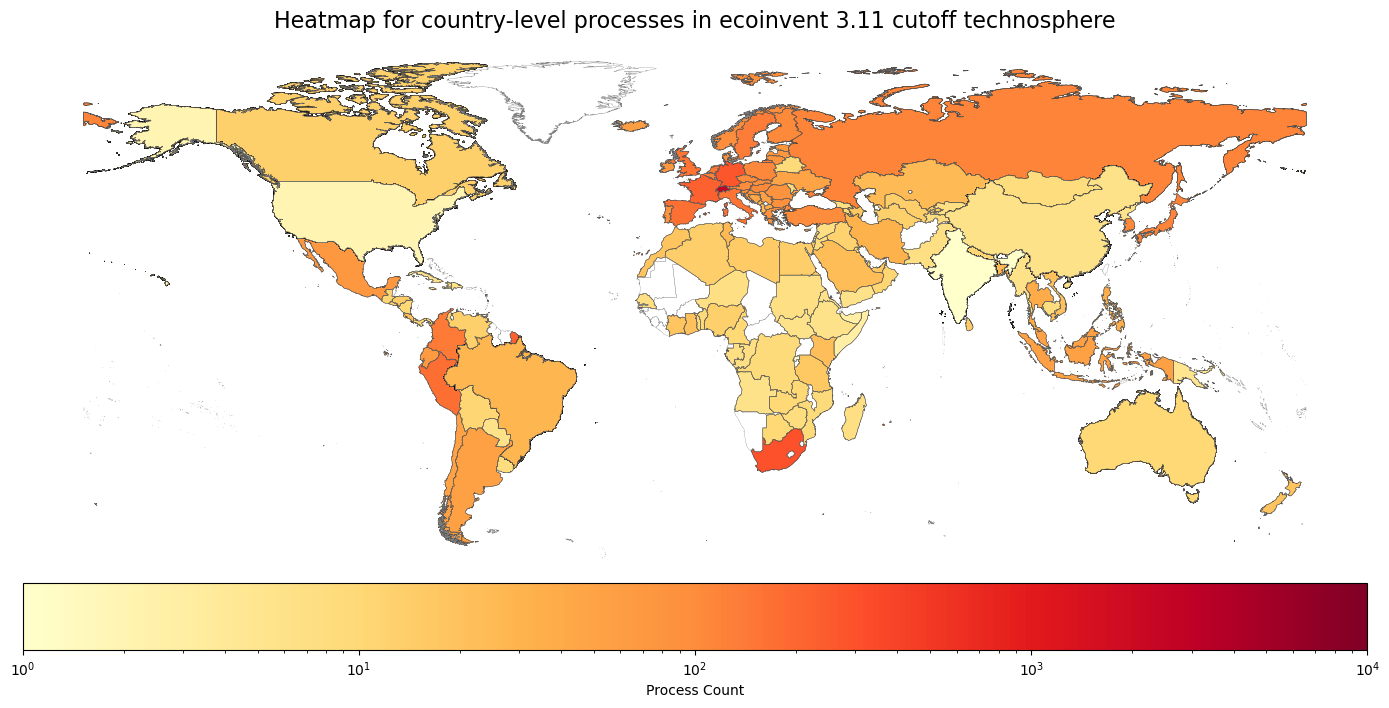

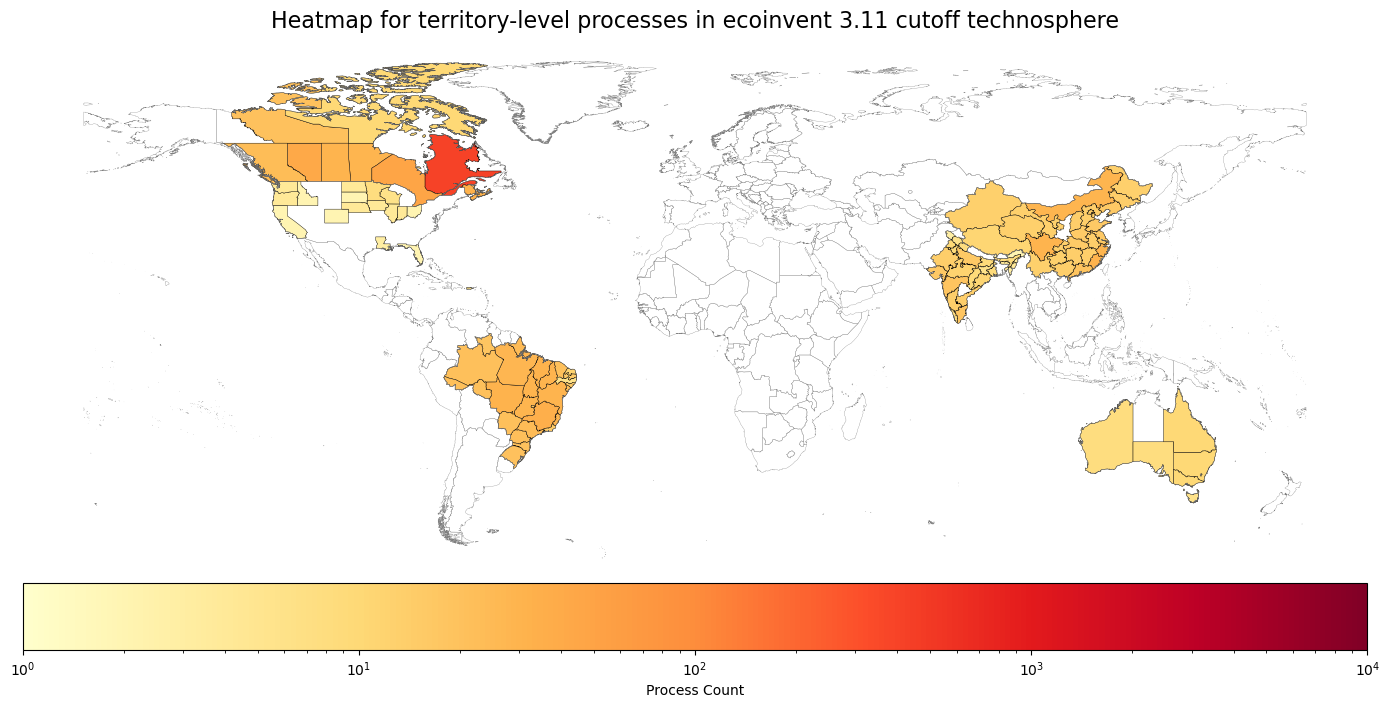

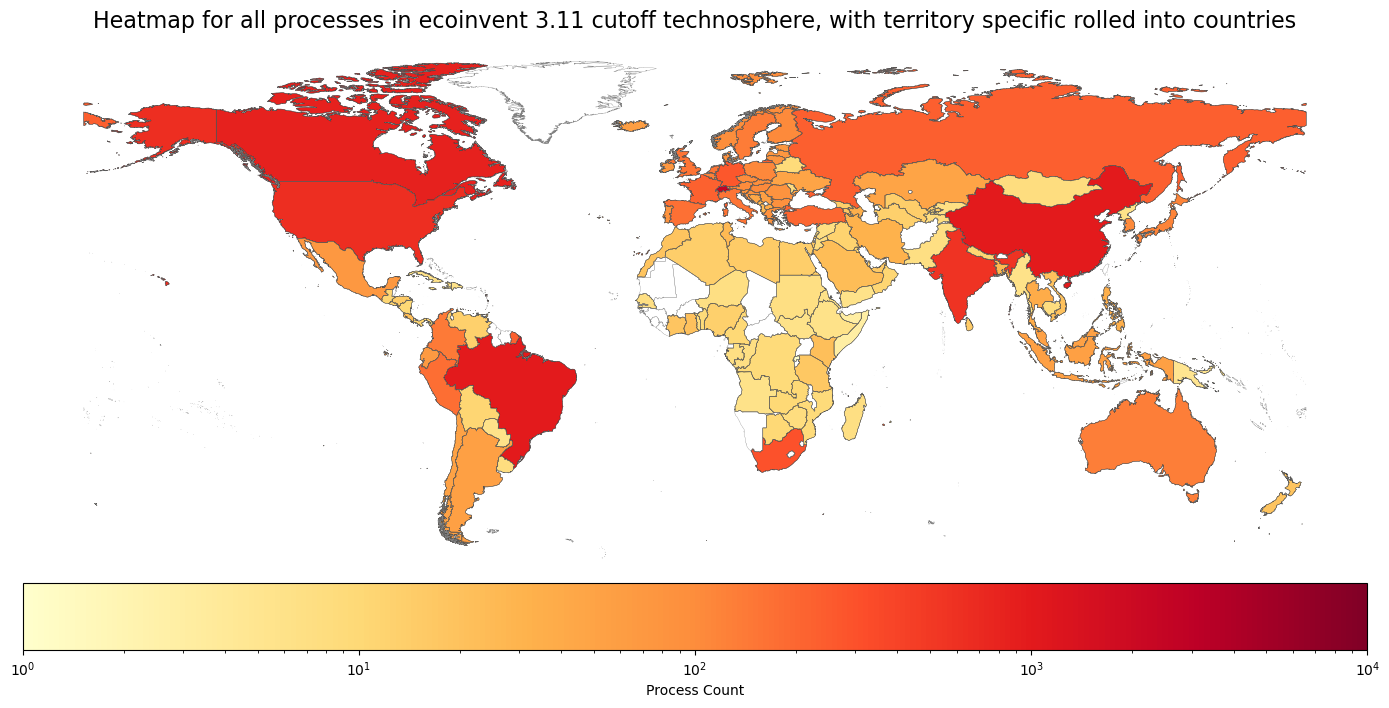

In [ ]:
i = 0
for name, frame in frames.items():
        if i < 2:
                col = "Process Count" 
        else:
                col="Process Count_summed"
        fig, ax = plt.subplots(1, figsize=(14, 16))
        plot_heatmap_frame(frame, ax, col=col)
        plt.title(f"Heatmap for {name}", fontsize=16)
        plt.tight_layout() 
        plt.savefig(f"{root}/Figures/Basic_Viz/Heatmaps/{name}.png",  bbox_inches='tight')
        i += 1
